In [1]:
import tensorflow as tf
import sonnet as snt

from PIL import Image, ImageOps
import cv2

import numpy as np

import os

import i3d

W0725 15:52:05.972422 140528858199680 deprecation_wrapper.py:119] From /usr/lib/python3.7/site-packages/sonnet/python/custom_getters/restore_initializer.py:27: The name tf.GraphKeys is deprecated. Please use tf.compat.v1.GraphKeys instead.

W0725 15:52:06.986760 140528858199680 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [2]:
# Proprecessing for image(scale and crop)
def reshape_img_pil(img):
    width, height = np.array(img).shape[0:2]
    min_ = min(height, width)
    ratio = float(256/float(min_))
    new_w = int(ratio*width)
    new_h = int(ratio*height)
    
    img_resize = np.array(img.resize((new_w, new_h), resample=Image.BILINEAR))
    img_scale = (img_resize/255.0)*2-1
    new_img = img_scale[int((new_h-224)/2):int((new_h+224)/2),int((new_w-224)/2):int((new_w+224)/2),:]
    
    return new_img

def reshape_cv2(img, type):
    width, height = img.shape[0:2]
    min_ = min(height, width)
    ratio = float(256/float(min_))
    new_w = int(ratio*width)
    new_h = int(ratio*height)
#     print(width, height, new_w, new_h)
#     print((new_h-224)/2, (new_h+224)/2, (new_w-224)/2, (new_w+224)/2)
    if type=='rgb':
        frame = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    else:
        frame = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    frame = cv2.resize(frame, (new_w,new_h), interpolation=cv2.INTER_LINEAR)
    frame = (frame/255.0)*2-1
    frame = frame[int((new_h-224)/2):int((new_h+224)/2),int((new_w-224)/2):int((new_w+224)/2)]
    
    return frame

In [3]:
def get_batch(idx, step, video_path, video_name, type):
    raw_images = []
    for i in range(step):
        if type == 'rgb':
            image_name = 'img_%05d.jpg'%(idx+1+i)
            if os.path.exists(os.path.join(video_path, image_name)):
                img = cv2.imread(os.path.join(video_path, image_name))
                img = reshape_cv2(img, type='rgb')
                raw_images.append(img)
        elif type == 'flow':
            flow_x_name = 'flow_x_%05d.jpg'%(idx+1+i)
            flow_y_name = 'flow_y_%05d.jpg'%(idx+1+i)
            if os.path.exists(os.path.join(video_path, flow_x_name)):
                flow_x_img = cv2.imread(os.path.join(video_path, flow_x_name))
                flow_y_img = cv2.imread(os.path.join(video_path, flow_y_name))
                
                flow_x_img = reshape_cv2(flow_x_img, type='flow')
                flow_y_img = reshape_cv2(flow_y_img, type='flow')
                
#                 print(flow_x_img.shape, flow_y_img.shape)
#                 flow = np.stack((flow_x_img, flow_y_img))
#                 print(flow.shape)
                flow = np.stack((flow_x_img, flow_y_img)).reshape(224,224,2)

                raw_images.append(flow)
    
    return np.array(raw_images)

In [4]:
image_size = 224
num_class = 20

sample_path = {
    'rgb': 'data/v_CricketShot_g04_c01_rgb.npy',
    'flow': 'data/v_CricketShot_g04_c01_flow.npy',
}

checkpoints = {
    'rgb_scratch': 'data/checkpoints/rgb_scratch/model.ckpt',
    'flow_scratch': 'data/checkpoints/flow_scratch/model.ckpt',
    'rgb_imagenet': 'data/checkpoints/rgb_imagenet/model.ckpt',
    'flow_imagenet': 'data/checkpoints/flow_imagenet/model.ckpt',
}

raw_path = {
    'val': '/data/th14_raw/val_optical_flow_rgb',
    'test': '/data/th14_raw/test_optical_flow_rgb',
}

save_paths = {
    'val_imagenet': '/data/th14_feature_i3d/feat_and_var/feat_imagenet/val_feat',
    'test_imagenet': '/data/th14_feature_i3d/feat_and_var/feat_imagenet/test_feat',
    'val_scratch': '/data/th14_feature_i3d/feat_and_var/feat_scratch/val_feat',
    'test_scratch': '/data/th14_feature_i3d/feat_and_var/feat_scratch/test_feat',
}

In [5]:
rgb_input = tf.placeholder(tf.float32, shape=(1,None,image_size,image_size,3))
flow_input = tf.placeholder(tf.float32, shape=(1,None,image_size,image_size,2))
with tf.variable_scope('RGB'):
    rgb_model = i3d.InceptionI3d(num_class+1, spatial_squeeze=True, final_endpoint='Mixed_5c')
    rgb_mixed5c, _ = rgb_model(rgb_input, is_training=False, dropout_keep_prob=1.0)
#         rgb_feat = tf.nn.avg_pool3d(rgb_mixed5c, ksize=[1, 2, 7, 7, 1],
#                              strides=[1, 1, 1, 1, 1], padding=snt.VALID)
    rgb_feat = rgb_mixed5c

rgb_variable_map = {}
for variable in tf.global_variables():
    if variable.name.split('/')[0] == 'RGB':
        rgb_variable_map[variable.name.replace(':0', '')] = variable
rgb_saver = tf.train.Saver(var_list=rgb_variable_map, reshape=True)
    
with tf.variable_scope('Flow'):
    flow_model = i3d.InceptionI3d(num_class+1,spatial_squeeze=True, final_endpoint='Mixed_5c')
    flow_mixed5c, _ = flow_model(flow_input, is_training=False, dropout_keep_prob=1.0)
#         flow_feat = tf.nn.avg_pool3d(flow_mixed5c, ksize=[1, 2, 7, 7, 1],
#                              strides=[1, 1, 1, 1, 1], padding=snt.VALID)
    flow_feat = flow_mixed5c
        
flow_variable_map = {}
for variable in tf.global_variables():
    if variable.name.split('/')[0] == 'Flow':
        flow_variable_map[variable.name.replace(':0', '')] = variable
flow_saver = tf.train.Saver(var_list=flow_variable_map, reshape=True)

W0725 15:52:12.992888 140528858199680 deprecation_wrapper.py:119] From /usr/lib/python3.7/site-packages/sonnet/python/modules/base.py:177: The name tf.make_template is deprecated. Please use tf.compat.v1.make_template instead.

W0725 15:52:13.001218 140528858199680 deprecation_wrapper.py:119] From /usr/lib/python3.7/site-packages/sonnet/python/modules/base.py:278: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0725 15:52:13.004653 140528858199680 deprecation_wrapper.py:119] From /usr/lib/python3.7/site-packages/sonnet/python/modules/conv.py:134: The name tf.Dimension is deprecated. Please use tf.compat.v1.Dimension instead.

W0725 15:52:13.009396 140528858199680 deprecation.py:506] From /usr/lib/python3.7/site-packages/sonnet/python/modules/conv.py:299: calling TruncatedNormal.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer inst

In [6]:
def get_mean_var(feat):
    feat = np.reshape(feat, (-1, 1024))
    mean = np.mean(feat, axis=0)
    var = np.var(feat, axis=0)
    feat_all = np.hstack((mean, var))
    return feat_all

In [19]:
def extract_feat(feat_extractor='imagenet', data_source='test'):
    mean = []
    var = []
    with tf.Session(config=tf.ConfigProto(gpu_options=tf.GPUOptions(per_process_gpu_memory_fraction=0.3))) as sess:
        feed_dict = {}
        
        rgb_feat_type = 'rgb' + '_' + feat_extractor
        flow_feat_type = 'flow' + '_' + feat_extractor
        
        rgb_saver.restore(sess, checkpoints[rgb_feat_type])
        flow_saver.restore(sess, checkpoints[flow_feat_type])
#         rgb_saver.restore(sess, checkpoints['rgb'])
#         flow_saver.restore(sess, checkpoints['flow'])
        
        tf.logging.info('RGB checkpoint restored')
        tf.logging.info('Flow checkpoint restored')
       
        feat_path = raw_path[data_source]
        
        save_pn = data_source + '_' + feat_extractor
        save_path = save_paths[save_pn]

        feat_step = 16

        video_list = os.listdir(feat_path)
#         print(len(video_list))
        for video in video_list:
#             video = 'video_test_0001292'
            
            video_path = os.path.join(feat_path, video)
#             if not os.path.exists(video_path):
#                 os.makedirs(video_path)
            print(video_path)
            num_frames = len(os.listdir(video_path))/3
            index = np.arange(num_frames-8, step=8)
#             print(len(index))
            for idx in index:
                rgb_batch = get_batch(idx, feat_step, video_path, video, type='rgb')
                flow_batch = get_batch(idx, feat_step, video_path, video, type='flow')

                rgb_arr = rgb_batch[np.newaxis, :]
#                 rgb_arr = (rgb_arr/255.0)*2-1
                flow_arr = flow_batch[np.newaxis, :]
#                 flow_arr = (flow_arr/255.0)*2-1

                feed_dict[rgb_input] = rgb_arr
                feed_dict[flow_input] = flow_arr

                rgb, flow = sess.run([rgb_feat, flow_feat], feed_dict=feed_dict)
#                 print(rgb.shape, flow.shape)
                rgb = get_mean_var(rgb)
                mean += list(rgb[:1024])
                var += list(rgb[1024:])
                flow = get_mean_var(flow)
                print(rgb.shape, flow.shape)
                save_name = video+'.mp4_'+str(float(idx+1))+'_'+str(float(str(idx+1+feat_step)))+'.npy'
                print(save_path,save_name)
            break
#                 np.save(os.path.join(save_path, 'rgb', save_name), rgb)
#                 np.save(os.path.join(save_path, 'flow', save_name), flow)
                
#             break
    return mean, var

In [20]:
mean, var = extract_feat()

/data/th14_raw/test_optical_flow_rgb/video_test_0000593
(2048,) (2048,)
/data/th14_feature_i3d/feat_and_var/feat_imagenet/test_feat video_test_0000593.mp4_1.0_17.0.npy
(2048,) (2048,)
/data/th14_feature_i3d/feat_and_var/feat_imagenet/test_feat video_test_0000593.mp4_9.0_25.0.npy
(2048,) (2048,)
/data/th14_feature_i3d/feat_and_var/feat_imagenet/test_feat video_test_0000593.mp4_17.0_33.0.npy
(2048,) (2048,)
/data/th14_feature_i3d/feat_and_var/feat_imagenet/test_feat video_test_0000593.mp4_25.0_41.0.npy
(2048,) (2048,)
/data/th14_feature_i3d/feat_and_var/feat_imagenet/test_feat video_test_0000593.mp4_33.0_49.0.npy
(2048,) (2048,)
/data/th14_feature_i3d/feat_and_var/feat_imagenet/test_feat video_test_0000593.mp4_41.0_57.0.npy
(2048,) (2048,)
/data/th14_feature_i3d/feat_and_var/feat_imagenet/test_feat video_test_0000593.mp4_49.0_65.0.npy
(2048,) (2048,)
/data/th14_feature_i3d/feat_and_var/feat_imagenet/test_feat video_test_0000593.mp4_57.0_73.0.npy
(2048,) (2048,)
/data/th14_feature_i3d/fea

(2048,) (2048,)
/data/th14_feature_i3d/feat_and_var/feat_imagenet/test_feat video_test_0000593.mp4_569.0_585.0.npy
(2048,) (2048,)
/data/th14_feature_i3d/feat_and_var/feat_imagenet/test_feat video_test_0000593.mp4_577.0_593.0.npy
(2048,) (2048,)
/data/th14_feature_i3d/feat_and_var/feat_imagenet/test_feat video_test_0000593.mp4_585.0_601.0.npy
(2048,) (2048,)
/data/th14_feature_i3d/feat_and_var/feat_imagenet/test_feat video_test_0000593.mp4_593.0_609.0.npy
(2048,) (2048,)
/data/th14_feature_i3d/feat_and_var/feat_imagenet/test_feat video_test_0000593.mp4_601.0_617.0.npy
(2048,) (2048,)
/data/th14_feature_i3d/feat_and_var/feat_imagenet/test_feat video_test_0000593.mp4_609.0_625.0.npy
(2048,) (2048,)
/data/th14_feature_i3d/feat_and_var/feat_imagenet/test_feat video_test_0000593.mp4_617.0_633.0.npy
(2048,) (2048,)
/data/th14_feature_i3d/feat_and_var/feat_imagenet/test_feat video_test_0000593.mp4_625.0_641.0.npy
(2048,) (2048,)
/data/th14_feature_i3d/feat_and_var/feat_imagenet/test_feat vide

(2048,) (2048,)
/data/th14_feature_i3d/feat_and_var/feat_imagenet/test_feat video_test_0000593.mp4_1137.0_1153.0.npy
(2048,) (2048,)
/data/th14_feature_i3d/feat_and_var/feat_imagenet/test_feat video_test_0000593.mp4_1145.0_1161.0.npy
(2048,) (2048,)
/data/th14_feature_i3d/feat_and_var/feat_imagenet/test_feat video_test_0000593.mp4_1153.0_1169.0.npy
(2048,) (2048,)
/data/th14_feature_i3d/feat_and_var/feat_imagenet/test_feat video_test_0000593.mp4_1161.0_1177.0.npy
(2048,) (2048,)
/data/th14_feature_i3d/feat_and_var/feat_imagenet/test_feat video_test_0000593.mp4_1169.0_1185.0.npy
(2048,) (2048,)
/data/th14_feature_i3d/feat_and_var/feat_imagenet/test_feat video_test_0000593.mp4_1177.0_1193.0.npy
(2048,) (2048,)
/data/th14_feature_i3d/feat_and_var/feat_imagenet/test_feat video_test_0000593.mp4_1185.0_1201.0.npy
(2048,) (2048,)
/data/th14_feature_i3d/feat_and_var/feat_imagenet/test_feat video_test_0000593.mp4_1193.0_1209.0.npy
(2048,) (2048,)
/data/th14_feature_i3d/feat_and_var/feat_imagene

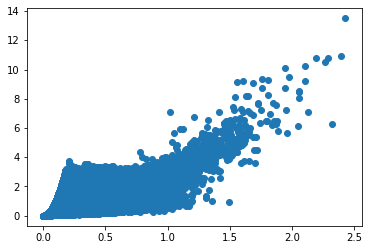

In [21]:
import matplotlib.pyplot as plt
plt.scatter(mean, var)
plt.show()